# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [2]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [3]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [4]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [5]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dealer.show())

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode
  
    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                
                
   ################################################################             
    def __init__(self):
        self.player_money = [10000]
        self.win_rate = 0
          
    def game(self, dealer: Dealer, agent: Agent, deck: Deck, it=10000, verbose=True):
        pmoney = 10000
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
                pmoney += 10 #10달러 참가비, 20달러 우승비
                self.player_money.append(self.player_money[-1]+10)
            elif episode[-1][-1] == 0:
                draw += 1
                pmoney += 0 #10달러 참가비,10달러 무승부
                self.player_money.append(self.player_money[-1])
            else:
                loss += 1
                pmoney -= 10 #10달러 참가비, 
                self.player_money.append(self.player_money[-1]-10)

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)
                print(" -- TOTAL Games Money: ", pmoney)
                
                self.win_rate = total_win  / (total_win + total_loss) * 100

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [6]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_action(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [7]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [8]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.game(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :31.979%
 -- 1000 Games WIN : 299 DRAW : 65 LOSS : 636
Total win rate : 31.979%
 -- TOTAL Games WIN : 299 DRAW : 65 LOSS : 636
 -- TOTAL Games Money:  6630
========== Training : Episode  2000  ===========
Recent 1000 games win rate :36.123%
 -- 1000 Games WIN : 341 DRAW : 56 LOSS : 603
Total win rate : 34.061%
 -- TOTAL Games WIN : 640 DRAW : 121 LOSS : 1239
 -- TOTAL Games Money:  4010
========== Training : Episode  3000  ===========
Recent 1000 games win rate :33.934%
 -- 1000 Games WIN : 320 DRAW : 57 LOSS : 623
Total win rate : 34.018%
 -- TOTAL Games WIN : 960 DRAW : 178 LOSS : 1862
 -- TOTAL Games Money:  980
========== Training : Episode  4000  ===========
Recent 1000 games win rate :34.289%
 -- 1000 Games WIN : 323 DRAW : 58 LOSS : 619
Total win rate : 34.086%
 -- TOTAL Games WIN : 1283 DRAW : 236 LOSS : 2481
 -- TOTAL Games Money:  -1980
========== Training : Episode  5000  ===========
Recent 1000 game

========== Training : Episode  36000  ===========
Recent 1000 games win rate :36.803%
 -- 1000 Games WIN : 343 DRAW : 68 LOSS : 589
Total win rate : 35.175%
 -- TOTAL Games WIN : 11906 DRAW : 2152 LOSS : 21942
 -- TOTAL Games Money:  -90360
========== Training : Episode  37000  ===========
Recent 1000 games win rate :34.837%
 -- 1000 Games WIN : 332 DRAW : 47 LOSS : 621
Total win rate : 35.166%
 -- TOTAL Games WIN : 12238 DRAW : 2199 LOSS : 22563
 -- TOTAL Games Money:  -93250
========== Training : Episode  38000  ===========
Recent 1000 games win rate :35.911%
 -- 1000 Games WIN : 339 DRAW : 56 LOSS : 605
Total win rate : 35.185%
 -- TOTAL Games WIN : 12577 DRAW : 2255 LOSS : 23168
 -- TOTAL Games Money:  -95910
========== Training : Episode  39000  ===========
Recent 1000 games win rate :37.259%
 -- 1000 Games WIN : 348 DRAW : 66 LOSS : 586
Total win rate : 35.238%
 -- TOTAL Games WIN : 12925 DRAW : 2321 LOSS : 23754
 -- TOTAL Games Money:  -98290
========== Training : Episode  40000

========== Training : Episode  70000  ===========
Recent 1000 games win rate :34.335%
 -- 1000 Games WIN : 320 DRAW : 68 LOSS : 612
Total win rate : 35.222%
 -- TOTAL Games WIN : 23194 DRAW : 4150 LOSS : 42656
 -- TOTAL Games Money:  -184620
========== Training : Episode  71000  ===========
Recent 1000 games win rate :36.809%
 -- 1000 Games WIN : 346 DRAW : 60 LOSS : 594
Total win rate : 35.245%
 -- TOTAL Games WIN : 23540 DRAW : 4210 LOSS : 43250
 -- TOTAL Games Money:  -187100
========== Training : Episode  72000  ===========
Recent 1000 games win rate :35.419%
 -- 1000 Games WIN : 334 DRAW : 57 LOSS : 609
Total win rate : 35.247%
 -- TOTAL Games WIN : 23874 DRAW : 4267 LOSS : 43859
 -- TOTAL Games Money:  -189850
========== Training : Episode  73000  ===========
Recent 1000 games win rate :37.073%
 -- 1000 Games WIN : 347 DRAW : 64 LOSS : 589
Total win rate : 35.272%
 -- TOTAL Games WIN : 24221 DRAW : 4331 LOSS : 44448
 -- TOTAL Games Money:  -192270
========== Training : Episode  7

========== Training : Episode  105000  ===========
Recent 1000 games win rate :35.487%
 -- 1000 Games WIN : 335 DRAW : 56 LOSS : 609
Total win rate : 35.227%
 -- TOTAL Games WIN : 34773 DRAW : 6288 LOSS : 63939
 -- TOTAL Games Money:  -281660
========== Training : Episode  106000  ===========
Recent 1000 games win rate :35.338%
 -- 1000 Games WIN : 335 DRAW : 52 LOSS : 613
Total win rate : 35.228%
 -- TOTAL Games WIN : 35108 DRAW : 6340 LOSS : 64552
 -- TOTAL Games Money:  -284440
========== Training : Episode  107000  ===========
Recent 1000 games win rate :32.655%
 -- 1000 Games WIN : 305 DRAW : 66 LOSS : 629
Total win rate : 35.204%
 -- TOTAL Games WIN : 35413 DRAW : 6406 LOSS : 65181
 -- TOTAL Games Money:  -287680
========== Training : Episode  108000  ===========
Recent 1000 games win rate :39.135%
 -- 1000 Games WIN : 371 DRAW : 52 LOSS : 577
Total win rate : 35.241%
 -- TOTAL Games WIN : 35784 DRAW : 6458 LOSS : 65758
 -- TOTAL Games Money:  -289740
========== Training : Episod

========== Training : Episode  139000  ===========
Recent 1000 games win rate :36.152%
 -- 1000 Games WIN : 342 DRAW : 54 LOSS : 604
Total win rate : 35.236%
 -- TOTAL Games WIN : 46028 DRAW : 8373 LOSS : 84599
 -- TOTAL Games Money:  -375710
========== Training : Episode  140000  ===========
Recent 1000 games win rate :35.054%
 -- 1000 Games WIN : 326 DRAW : 70 LOSS : 604
Total win rate : 35.235%
 -- TOTAL Games WIN : 46354 DRAW : 8443 LOSS : 85203
 -- TOTAL Games Money:  -378490
========== Training : Episode  141000  ===========
Recent 1000 games win rate :36.102%
 -- 1000 Games WIN : 339 DRAW : 61 LOSS : 600
Total win rate : 35.241%
 -- TOTAL Games WIN : 46693 DRAW : 8504 LOSS : 85803
 -- TOTAL Games Money:  -381100
========== Training : Episode  142000  ===========
Recent 1000 games win rate :33.126%
 -- 1000 Games WIN : 319 DRAW : 37 LOSS : 644
Total win rate : 35.226%
 -- TOTAL Games WIN : 47012 DRAW : 8541 LOSS : 86447
 -- TOTAL Games Money:  -384350
========== Training : Episod

========== Training : Episode  175000  ===========
Recent 1000 games win rate :33.970%
 -- 1000 Games WIN : 320 DRAW : 58 LOSS : 622
Total win rate : 35.289%
 -- TOTAL Games WIN : 58060 DRAW : 10474 LOSS : 106466
 -- TOTAL Games Money:  -474060
========== Training : Episode  176000  ===========
Recent 1000 games win rate :37.259%
 -- 1000 Games WIN : 348 DRAW : 66 LOSS : 586
Total win rate : 35.300%
 -- TOTAL Games WIN : 58408 DRAW : 10540 LOSS : 107052
 -- TOTAL Games Money:  -476440
========== Training : Episode  177000  ===========
Recent 1000 games win rate :33.156%
 -- 1000 Games WIN : 312 DRAW : 59 LOSS : 629
Total win rate : 35.288%
 -- TOTAL Games WIN : 58720 DRAW : 10599 LOSS : 107681
 -- TOTAL Games Money:  -479610
========== Training : Episode  178000  ===========
Recent 1000 games win rate :35.080%
 -- 1000 Games WIN : 328 DRAW : 65 LOSS : 607
Total win rate : 35.287%
 -- TOTAL Games WIN : 59048 DRAW : 10664 LOSS : 108288
 -- TOTAL Games Money:  -482400
========== Training 

 -- 1000 Games WIN : 346 DRAW : 59 LOSS : 595
Total win rate : 35.245%
 -- TOTAL Games WIN : 70233 DRAW : 12727 LOSS : 129040
 -- TOTAL Games Money:  -578070
========== Training : Episode  213000  ===========
Recent 1000 games win rate :36.004%
 -- 1000 Games WIN : 337 DRAW : 64 LOSS : 599
Total win rate : 35.248%
 -- TOTAL Games WIN : 70570 DRAW : 12791 LOSS : 129639
 -- TOTAL Games Money:  -580690
========== Training : Episode  214000  ===========
Recent 1000 games win rate :33.873%
 -- 1000 Games WIN : 314 DRAW : 73 LOSS : 613
Total win rate : 35.242%
 -- TOTAL Games WIN : 70884 DRAW : 12864 LOSS : 130252
 -- TOTAL Games Money:  -583680
========== Training : Episode  215000  ===========
Recent 1000 games win rate :33.333%
 -- 1000 Games WIN : 313 DRAW : 61 LOSS : 626
Total win rate : 35.233%
 -- TOTAL Games WIN : 71197 DRAW : 12925 LOSS : 130878
 -- TOTAL Games Money:  -586810
========== Training : Episode  216000  ===========
Recent 1000 games win rate :31.450%
 -- 1000 Games WIN :

========== Training : Episode  248000  ===========
Recent 1000 games win rate :34.947%
 -- 1000 Games WIN : 332 DRAW : 50 LOSS : 618
Total win rate : 35.243%
 -- TOTAL Games WIN : 82178 DRAW : 14822 LOSS : 151000
 -- TOTAL Games Money:  -678220
========== Training : Episode  249000  ===========
Recent 1000 games win rate :35.250%
 -- 1000 Games WIN : 331 DRAW : 61 LOSS : 608
Total win rate : 35.243%
 -- TOTAL Games WIN : 82509 DRAW : 14883 LOSS : 151608
 -- TOTAL Games Money:  -680990
========== Training : Episode  250000  ===========
Recent 1000 games win rate :35.313%
 -- 1000 Games WIN : 333 DRAW : 57 LOSS : 610
Total win rate : 35.243%
 -- TOTAL Games WIN : 82842 DRAW : 14940 LOSS : 152218
 -- TOTAL Games Money:  -683760
========== Training : Episode  251000  ===========
Recent 1000 games win rate :36.656%
 -- 1000 Games WIN : 342 DRAW : 67 LOSS : 591
Total win rate : 35.249%
 -- TOTAL Games WIN : 83184 DRAW : 15007 LOSS : 152809
 -- TOTAL Games Money:  -686250
========== Training 

========== Training : Episode  283000  ===========
Recent 1000 games win rate :36.364%
 -- 1000 Games WIN : 340 DRAW : 65 LOSS : 595
Total win rate : 35.247%
 -- TOTAL Games WIN : 93796 DRAW : 16890 LOSS : 172314
 -- TOTAL Games Money:  -775180
========== Training : Episode  284000  ===========
Recent 1000 games win rate :35.000%
 -- 1000 Games WIN : 329 DRAW : 60 LOSS : 611
Total win rate : 35.246%
 -- TOTAL Games WIN : 94125 DRAW : 16950 LOSS : 172925
 -- TOTAL Games Money:  -778000
========== Training : Episode  285000  ===========
Recent 1000 games win rate :37.393%
 -- 1000 Games WIN : 350 DRAW : 64 LOSS : 586
Total win rate : 35.254%
 -- TOTAL Games WIN : 94475 DRAW : 17014 LOSS : 173511
 -- TOTAL Games Money:  -780360
========== Training : Episode  286000  ===========
Recent 1000 games win rate :37.234%
 -- 1000 Games WIN : 350 DRAW : 60 LOSS : 590
Total win rate : 35.261%
 -- TOTAL Games WIN : 94825 DRAW : 17074 LOSS : 174101
 -- TOTAL Games Money:  -782760
========== Training 

========== Training : Episode  319000  ===========
Recent 1000 games win rate :35.889%
 -- 1000 Games WIN : 337 DRAW : 61 LOSS : 602
Total win rate : 35.291%
 -- TOTAL Games WIN : 105830 DRAW : 19121 LOSS : 194049
 -- TOTAL Games Money:  -872190
========== Training : Episode  320000  ===========
Recent 1000 games win rate :37.671%
 -- 1000 Games WIN : 359 DRAW : 47 LOSS : 594
Total win rate : 35.298%
 -- TOTAL Games WIN : 106189 DRAW : 19168 LOSS : 194643
 -- TOTAL Games Money:  -874540
========== Training : Episode  321000  ===========
Recent 1000 games win rate :35.022%
 -- 1000 Games WIN : 325 DRAW : 72 LOSS : 603
Total win rate : 35.298%
 -- TOTAL Games WIN : 106514 DRAW : 19240 LOSS : 195246
 -- TOTAL Games Money:  -877320
========== Training : Episode  322000  ===========
Recent 1000 games win rate :34.681%
 -- 1000 Games WIN : 326 DRAW : 60 LOSS : 614
Total win rate : 35.296%
 -- TOTAL Games WIN : 106840 DRAW : 19300 LOSS : 195860
 -- TOTAL Games Money:  -880200
========== Train

========== Training : Episode  354000  ===========
Recent 1000 games win rate :34.088%
 -- 1000 Games WIN : 316 DRAW : 73 LOSS : 611
Total win rate : 35.370%
 -- TOTAL Games WIN : 117710 DRAW : 21203 LOSS : 215087
 -- TOTAL Games Money:  -963770
========== Training : Episode  355000  ===========
Recent 1000 games win rate :35.016%
 -- 1000 Games WIN : 333 DRAW : 49 LOSS : 618
Total win rate : 35.369%
 -- TOTAL Games WIN : 118043 DRAW : 21252 LOSS : 215705
 -- TOTAL Games Money:  -966620
========== Training : Episode  356000  ===========
Recent 1000 games win rate :38.552%
 -- 1000 Games WIN : 362 DRAW : 61 LOSS : 577
Total win rate : 35.378%
 -- TOTAL Games WIN : 118405 DRAW : 21313 LOSS : 216282
 -- TOTAL Games Money:  -968770
========== Training : Episode  357000  ===========
Recent 1000 games win rate :35.101%
 -- 1000 Games WIN : 331 DRAW : 57 LOSS : 612
Total win rate : 35.377%
 -- TOTAL Games WIN : 118736 DRAW : 21370 LOSS : 216894
 -- TOTAL Games Money:  -971580
========== Train

========== Training : Episode  388000  ===========
Recent 1000 games win rate :33.478%
 -- 1000 Games WIN : 309 DRAW : 77 LOSS : 614
Total win rate : 35.403%
 -- TOTAL Games WIN : 129152 DRAW : 23192 LOSS : 235656
 -- TOTAL Games Money:  -1055040
========== Training : Episode  389000  ===========
Recent 1000 games win rate :39.103%
 -- 1000 Games WIN : 375 DRAW : 41 LOSS : 584
Total win rate : 35.412%
 -- TOTAL Games WIN : 129527 DRAW : 23233 LOSS : 236240
 -- TOTAL Games Money:  -1057130
========== Training : Episode  390000  ===========
Recent 1000 games win rate :34.428%
 -- 1000 Games WIN : 325 DRAW : 56 LOSS : 619
Total win rate : 35.410%
 -- TOTAL Games WIN : 129852 DRAW : 23289 LOSS : 236859
 -- TOTAL Games Money:  -1060070
========== Training : Episode  391000  ===========
Recent 1000 games win rate :34.755%
 -- 1000 Games WIN : 326 DRAW : 62 LOSS : 612
Total win rate : 35.408%
 -- TOTAL Games WIN : 130178 DRAW : 23351 LOSS : 237471
 -- TOTAL Games Money:  -1062930
========== T

========== Training : Episode  424000  ===========
Recent 1000 games win rate :34.611%
 -- 1000 Games WIN : 325 DRAW : 61 LOSS : 614
Total win rate : 35.384%
 -- TOTAL Games WIN : 141051 DRAW : 25373 LOSS : 257576
 -- TOTAL Games Money:  -1155250
========== Training : Episode  425000  ===========
Recent 1000 games win rate :35.941%
 -- 1000 Games WIN : 340 DRAW : 54 LOSS : 606
Total win rate : 35.386%
 -- TOTAL Games WIN : 141391 DRAW : 25427 LOSS : 258182
 -- TOTAL Games Money:  -1157910
========== Training : Episode  426000  ===========
Recent 1000 games win rate :34.497%
 -- 1000 Games WIN : 326 DRAW : 55 LOSS : 619
Total win rate : 35.383%
 -- TOTAL Games WIN : 141717 DRAW : 25482 LOSS : 258801
 -- TOTAL Games Money:  -1160840
========== Training : Episode  427000  ===========
Recent 1000 games win rate :36.170%
 -- 1000 Games WIN : 340 DRAW : 60 LOSS : 600
Total win rate : 35.385%
 -- TOTAL Games WIN : 142057 DRAW : 25542 LOSS : 259401
 -- TOTAL Games Money:  -1163440
========== T

========== Training : Episode  461000  ===========
Recent 1000 games win rate :33.262%
 -- 1000 Games WIN : 312 DRAW : 62 LOSS : 626
Total win rate : 35.354%
 -- TOTAL Games WIN : 153228 DRAW : 27589 LOSS : 280183
 -- TOTAL Games Money:  -1259550
========== Training : Episode  462000  ===========
Recent 1000 games win rate :33.298%
 -- 1000 Games WIN : 316 DRAW : 51 LOSS : 633
Total win rate : 35.349%
 -- TOTAL Games WIN : 153544 DRAW : 27640 LOSS : 280816
 -- TOTAL Games Money:  -1262720
========== Training : Episode  463000  ===========
Recent 1000 games win rate :34.084%
 -- 1000 Games WIN : 318 DRAW : 67 LOSS : 615
Total win rate : 35.347%
 -- TOTAL Games WIN : 153862 DRAW : 27707 LOSS : 281431
 -- TOTAL Games Money:  -1265690
========== Training : Episode  464000  ===========
Recent 1000 games win rate :36.132%
 -- 1000 Games WIN : 340 DRAW : 59 LOSS : 601
Total win rate : 35.348%
 -- TOTAL Games WIN : 154202 DRAW : 27766 LOSS : 282032
 -- TOTAL Games Money:  -1268300
========== T

========== Training : Episode  496000  ===========
Recent 1000 games win rate :36.903%
 -- 1000 Games WIN : 348 DRAW : 57 LOSS : 595
Total win rate : 35.338%
 -- TOTAL Games WIN : 164806 DRAW : 29628 LOSS : 301566
 -- TOTAL Games Money:  -1357600
========== Training : Episode  497000  ===========
Recent 1000 games win rate :36.670%
 -- 1000 Games WIN : 348 DRAW : 51 LOSS : 601
Total win rate : 35.341%
 -- TOTAL Games WIN : 165154 DRAW : 29679 LOSS : 302167
 -- TOTAL Games Money:  -1360130
========== Training : Episode  498000  ===========
Recent 1000 games win rate :34.783%
 -- 1000 Games WIN : 328 DRAW : 57 LOSS : 615
Total win rate : 35.339%
 -- TOTAL Games WIN : 165482 DRAW : 29736 LOSS : 302782
 -- TOTAL Games Money:  -1363000
========== Training : Episode  499000  ===========
Recent 1000 games win rate :36.698%
 -- 1000 Games WIN : 349 DRAW : 49 LOSS : 602
Total win rate : 35.342%
 -- TOTAL Games WIN : 165831 DRAW : 29785 LOSS : 303384
 -- TOTAL Games Money:  -1365530
========== T

========== Training : Episode  534000  ===========
Recent 1000 games win rate :34.611%
 -- 1000 Games WIN : 325 DRAW : 61 LOSS : 614
Total win rate : 35.298%
 -- TOTAL Games WIN : 177242 DRAW : 31871 LOSS : 324887
 -- TOTAL Games Money:  -1466450
========== Training : Episode  535000  ===========
Recent 1000 games win rate :34.698%
 -- 1000 Games WIN : 322 DRAW : 72 LOSS : 606
Total win rate : 35.297%
 -- TOTAL Games WIN : 177564 DRAW : 31943 LOSS : 325493
 -- TOTAL Games Money:  -1469290
========== Training : Episode  536000  ===========
Recent 1000 games win rate :37.286%
 -- 1000 Games WIN : 349 DRAW : 64 LOSS : 587
Total win rate : 35.301%
 -- TOTAL Games WIN : 177913 DRAW : 32007 LOSS : 326080
 -- TOTAL Games Money:  -1471670
========== Training : Episode  537000  ===========
Recent 1000 games win rate :37.972%
 -- 1000 Games WIN : 352 DRAW : 73 LOSS : 575
Total win rate : 35.306%
 -- TOTAL Games WIN : 178265 DRAW : 32080 LOSS : 326655
 -- TOTAL Games Money:  -1473900
========== T

========== Training : Episode  571000  ===========
Recent 1000 games win rate :36.982%
 -- 1000 Games WIN : 348 DRAW : 59 LOSS : 593
Total win rate : 35.302%
 -- TOTAL Games WIN : 189542 DRAW : 34079 LOSS : 347379
 -- TOTAL Games Money:  -1568370
========== Training : Episode  572000  ===========
Recent 1000 games win rate :34.936%
 -- 1000 Games WIN : 327 DRAW : 64 LOSS : 609
Total win rate : 35.301%
 -- TOTAL Games WIN : 189869 DRAW : 34143 LOSS : 347988
 -- TOTAL Games Money:  -1571190
========== Training : Episode  573000  ===========
Recent 1000 games win rate :35.158%
 -- 1000 Games WIN : 334 DRAW : 50 LOSS : 616
Total win rate : 35.301%
 -- TOTAL Games WIN : 190203 DRAW : 34193 LOSS : 348604
 -- TOTAL Games Money:  -1574010
========== Training : Episode  574000  ===========
Recent 1000 games win rate :35.344%
 -- 1000 Games WIN : 334 DRAW : 55 LOSS : 611
Total win rate : 35.301%
 -- TOTAL Games WIN : 190537 DRAW : 34248 LOSS : 349215
 -- TOTAL Games Money:  -1576780
========== T

========== Training : Episode  606000  ===========
Recent 1000 games win rate :37.367%
 -- 1000 Games WIN : 352 DRAW : 58 LOSS : 590
Total win rate : 35.323%
 -- TOTAL Games WIN : 201274 DRAW : 36197 LOSS : 368529
 -- TOTAL Games Money:  -1662550
========== Training : Episode  607000  ===========
Recent 1000 games win rate :34.006%
 -- 1000 Games WIN : 320 DRAW : 59 LOSS : 621
Total win rate : 35.321%
 -- TOTAL Games WIN : 201594 DRAW : 36256 LOSS : 369150
 -- TOTAL Games Money:  -1665560
========== Training : Episode  608000  ===========
Recent 1000 games win rate :40.768%
 -- 1000 Games WIN : 382 DRAW : 63 LOSS : 555
Total win rate : 35.330%
 -- TOTAL Games WIN : 201976 DRAW : 36319 LOSS : 369705
 -- TOTAL Games Money:  -1667290
========== Training : Episode  609000  ===========
Recent 1000 games win rate :35.307%
 -- 1000 Games WIN : 334 DRAW : 54 LOSS : 612
Total win rate : 35.330%
 -- TOTAL Games WIN : 202310 DRAW : 36373 LOSS : 370317
 -- TOTAL Games Money:  -1670070
========== T

 -- TOTAL Games Money:  -1751870
========== Training : Episode  640000  ===========
Recent 1000 games win rate :36.831%
 -- 1000 Games WIN : 351 DRAW : 47 LOSS : 602
Total win rate : 35.341%
 -- TOTAL Games WIN : 212686 DRAW : 38190 LOSS : 389124
 -- TOTAL Games Money:  -1754380
========== Training : Episode  641000  ===========
Recent 1000 games win rate :33.655%
 -- 1000 Games WIN : 314 DRAW : 67 LOSS : 619
Total win rate : 35.338%
 -- TOTAL Games WIN : 213000 DRAW : 38257 LOSS : 389743
 -- TOTAL Games Money:  -1757430
========== Training : Episode  642000  ===========
Recent 1000 games win rate :35.624%
 -- 1000 Games WIN : 337 DRAW : 54 LOSS : 609
Total win rate : 35.339%
 -- TOTAL Games WIN : 213337 DRAW : 38311 LOSS : 390352
 -- TOTAL Games Money:  -1760150
========== Training : Episode  643000  ===========
Recent 1000 games win rate :37.365%
 -- 1000 Games WIN : 346 DRAW : 74 LOSS : 580
Total win rate : 35.342%
 -- TOTAL Games WIN : 213683 DRAW : 38385 LOSS : 390932
 -- TOTAL Ga

 -- 1000 Games WIN : 327 DRAW : 68 LOSS : 605
Total win rate : 35.327%
 -- TOTAL Games WIN : 225197 DRAW : 40530 LOSS : 412273
 -- TOTAL Games Money:  -1860760
========== Training : Episode  679000  ===========
Recent 1000 games win rate :36.188%
 -- 1000 Games WIN : 338 DRAW : 66 LOSS : 596
Total win rate : 35.328%
 -- TOTAL Games WIN : 225535 DRAW : 40596 LOSS : 412869
 -- TOTAL Games Money:  -1863340
========== Training : Episode  680000  ===========
Recent 1000 games win rate :34.159%
 -- 1000 Games WIN : 317 DRAW : 72 LOSS : 611
Total win rate : 35.326%
 -- TOTAL Games WIN : 225852 DRAW : 40668 LOSS : 413480
 -- TOTAL Games Money:  -1866280
========== Training : Episode  681000  ===========
Recent 1000 games win rate :39.979%
 -- 1000 Games WIN : 379 DRAW : 52 LOSS : 569
Total win rate : 35.333%
 -- TOTAL Games WIN : 226231 DRAW : 40720 LOSS : 414049
 -- TOTAL Games Money:  -1868180
========== Training : Episode  682000  ===========
Recent 1000 games win rate :39.130%
 -- 1000 Gam

========== Training : Episode  712000  ===========
Recent 1000 games win rate :35.669%
 -- 1000 Games WIN : 336 DRAW : 58 LOSS : 606
Total win rate : 35.336%
 -- TOTAL Games WIN : 236565 DRAW : 42533 LOSS : 432902
 -- TOTAL Games Money:  -1953370
========== Training : Episode  713000  ===========
Recent 1000 games win rate :34.824%
 -- 1000 Games WIN : 327 DRAW : 61 LOSS : 612
Total win rate : 35.336%
 -- TOTAL Games WIN : 236892 DRAW : 42594 LOSS : 433514
 -- TOTAL Games Money:  -1956220
========== Training : Episode  714000  ===========
Recent 1000 games win rate :33.966%
 -- 1000 Games WIN : 322 DRAW : 52 LOSS : 626
Total win rate : 35.334%
 -- TOTAL Games WIN : 237214 DRAW : 42646 LOSS : 434140
 -- TOTAL Games Money:  -1959260
========== Training : Episode  715000  ===========
Recent 1000 games win rate :34.249%
 -- 1000 Games WIN : 324 DRAW : 54 LOSS : 622
Total win rate : 35.332%
 -- TOTAL Games WIN : 237538 DRAW : 42700 LOSS : 434762
 -- TOTAL Games Money:  -1962240
========== T

 -- TOTAL Games WIN : 248404 DRAW : 44658 LOSS : 454938
 -- TOTAL Games Money:  -2055340
========== Training : Episode  749000  ===========
Recent 1000 games win rate :35.699%
 -- 1000 Games WIN : 337 DRAW : 56 LOSS : 607
Total win rate : 35.318%
 -- TOTAL Games WIN : 248741 DRAW : 44714 LOSS : 455545
 -- TOTAL Games Money:  -2058040
========== Training : Episode  750000  ===========
Recent 1000 games win rate :35.722%
 -- 1000 Games WIN : 334 DRAW : 65 LOSS : 601
Total win rate : 35.319%
 -- TOTAL Games WIN : 249075 DRAW : 44779 LOSS : 456146
 -- TOTAL Games Money:  -2060710
========== Training : Episode  751000  ===========
Recent 1000 games win rate :38.004%
 -- 1000 Games WIN : 358 DRAW : 58 LOSS : 584
Total win rate : 35.322%
 -- TOTAL Games WIN : 249433 DRAW : 44837 LOSS : 456730
 -- TOTAL Games Money:  -2062970
========== Training : Episode  752000  ===========
Recent 1000 games win rate :34.352%
 -- 1000 Games WIN : 326 DRAW : 51 LOSS : 623
Total win rate : 35.321%
 -- TOTAL Ga

 -- 1000 Games WIN : 324 DRAW : 61 LOSS : 615
Total win rate : 35.307%
 -- TOTAL Games WIN : 259954 DRAW : 46730 LOSS : 476316
 -- TOTAL Games Money:  -2153620
========== Training : Episode  784000  ===========
Recent 1000 games win rate :34.773%
 -- 1000 Games WIN : 330 DRAW : 51 LOSS : 619
Total win rate : 35.306%
 -- TOTAL Games WIN : 260284 DRAW : 46781 LOSS : 476935
 -- TOTAL Games Money:  -2156510
========== Training : Episode  785000  ===========
Recent 1000 games win rate :35.722%
 -- 1000 Games WIN : 334 DRAW : 65 LOSS : 601
Total win rate : 35.307%
 -- TOTAL Games WIN : 260618 DRAW : 46846 LOSS : 477536
 -- TOTAL Games Money:  -2159180
========== Training : Episode  786000  ===========
Recent 1000 games win rate :33.934%
 -- 1000 Games WIN : 320 DRAW : 57 LOSS : 623
Total win rate : 35.305%
 -- TOTAL Games WIN : 260938 DRAW : 46903 LOSS : 478159
 -- TOTAL Games Money:  -2162210
========== Training : Episode  787000  ===========
Recent 1000 games win rate :34.388%
 -- 1000 Gam

========== Training : Episode  818000  ===========
Recent 1000 games win rate :34.746%
 -- 1000 Games WIN : 328 DRAW : 56 LOSS : 616
Total win rate : 35.313%
 -- TOTAL Games WIN : 271632 DRAW : 48793 LOSS : 497575
 -- TOTAL Games Money:  -2249430
========== Training : Episode  819000  ===========
Recent 1000 games win rate :35.919%
 -- 1000 Games WIN : 338 DRAW : 59 LOSS : 603
Total win rate : 35.314%
 -- TOTAL Games WIN : 271970 DRAW : 48852 LOSS : 498178
 -- TOTAL Games Money:  -2252080
========== Training : Episode  820000  ===========
Recent 1000 games win rate :35.064%
 -- 1000 Games WIN : 331 DRAW : 56 LOSS : 613
Total win rate : 35.314%
 -- TOTAL Games WIN : 272301 DRAW : 48908 LOSS : 498791
 -- TOTAL Games Money:  -2254900
========== Training : Episode  821000  ===========
Recent 1000 games win rate :36.325%
 -- 1000 Games WIN : 340 DRAW : 64 LOSS : 596
Total win rate : 35.315%
 -- TOTAL Games WIN : 272641 DRAW : 48972 LOSS : 499387
 -- TOTAL Games Money:  -2257460
========== T

========== Training : Episode  853000  ===========
Recent 1000 games win rate :36.229%
 -- 1000 Games WIN : 342 DRAW : 56 LOSS : 602
Total win rate : 35.306%
 -- TOTAL Games WIN : 283189 DRAW : 50901 LOSS : 518910
 -- TOTAL Games Money:  -2347210
========== Training : Episode  854000  ===========
Recent 1000 games win rate :35.730%
 -- 1000 Games WIN : 333 DRAW : 68 LOSS : 599
Total win rate : 35.306%
 -- TOTAL Games WIN : 283522 DRAW : 50969 LOSS : 519509
 -- TOTAL Games Money:  -2349870
========== Training : Episode  855000  ===========
Recent 1000 games win rate :33.474%
 -- 1000 Games WIN : 317 DRAW : 53 LOSS : 630
Total win rate : 35.304%
 -- TOTAL Games WIN : 283839 DRAW : 51022 LOSS : 520139
 -- TOTAL Games Money:  -2353000
========== Training : Episode  856000  ===========
Recent 1000 games win rate :38.965%
 -- 1000 Games WIN : 369 DRAW : 53 LOSS : 578
Total win rate : 35.309%
 -- TOTAL Games WIN : 284208 DRAW : 51075 LOSS : 520717
 -- TOTAL Games Money:  -2355090
========== T

========== Training : Episode  888000  ===========
Recent 1000 games win rate :34.509%
 -- 1000 Games WIN : 323 DRAW : 64 LOSS : 613
Total win rate : 35.322%
 -- TOTAL Games WIN : 294928 DRAW : 53024 LOSS : 540048
 -- TOTAL Games Money:  -2441200
========== Training : Episode  889000  ===========
Recent 1000 games win rate :36.653%
 -- 1000 Games WIN : 346 DRAW : 56 LOSS : 598
Total win rate : 35.323%
 -- TOTAL Games WIN : 295274 DRAW : 53080 LOSS : 540646
 -- TOTAL Games Money:  -2443720
========== Training : Episode  890000  ===========
Recent 1000 games win rate :33.546%
 -- 1000 Games WIN : 315 DRAW : 61 LOSS : 624
Total win rate : 35.321%
 -- TOTAL Games WIN : 295589 DRAW : 53141 LOSS : 541270
 -- TOTAL Games Money:  -2446810
========== Training : Episode  891000  ===========
Recent 1000 games win rate :36.267%
 -- 1000 Games WIN : 342 DRAW : 57 LOSS : 601
Total win rate : 35.322%
 -- TOTAL Games WIN : 295931 DRAW : 53198 LOSS : 541871
 -- TOTAL Games Money:  -2449400
========== T

 -- TOTAL Games WIN : 305798 DRAW : 55020 LOSS : 560182
 -- TOTAL Games Money:  -2533840
========== Training : Episode  922000  ===========
Recent 1000 games win rate :34.899%
 -- 1000 Games WIN : 327 DRAW : 63 LOSS : 610
Total win rate : 35.312%
 -- TOTAL Games WIN : 306125 DRAW : 55083 LOSS : 560792
 -- TOTAL Games Money:  -2536670
========== Training : Episode  923000  ===========
Recent 1000 games win rate :34.472%
 -- 1000 Games WIN : 323 DRAW : 63 LOSS : 614
Total win rate : 35.311%
 -- TOTAL Games WIN : 306448 DRAW : 55146 LOSS : 561406
 -- TOTAL Games Money:  -2539580
========== Training : Episode  924000  ===========
Recent 1000 games win rate :34.857%
 -- 1000 Games WIN : 328 DRAW : 59 LOSS : 613
Total win rate : 35.311%
 -- TOTAL Games WIN : 306776 DRAW : 55205 LOSS : 562019
 -- TOTAL Games Money:  -2542430
========== Training : Episode  925000  ===========
Recent 1000 games win rate :34.292%
 -- 1000 Games WIN : 322 DRAW : 61 LOSS : 617
Total win rate : 35.309%
 -- TOTAL Ga

========== Training : Episode  956000  ===========
Recent 1000 games win rate :33.405%
 -- 1000 Games WIN : 312 DRAW : 66 LOSS : 622
Total win rate : 35.310%
 -- TOTAL Games WIN : 317380 DRAW : 57152 LOSS : 581468
 -- TOTAL Games Money:  -2630880
========== Training : Episode  957000  ===========
Recent 1000 games win rate :34.607%
 -- 1000 Games WIN : 326 DRAW : 58 LOSS : 616
Total win rate : 35.309%
 -- TOTAL Games WIN : 317706 DRAW : 57210 LOSS : 582084
 -- TOTAL Games Money:  -2633780
========== Training : Episode  958000  ===========
Recent 1000 games win rate :34.852%
 -- 1000 Games WIN : 329 DRAW : 56 LOSS : 615
Total win rate : 35.308%
 -- TOTAL Games WIN : 318035 DRAW : 57266 LOSS : 582699
 -- TOTAL Games Money:  -2636640
========== Training : Episode  959000  ===========
Recent 1000 games win rate :33.761%
 -- 1000 Games WIN : 316 DRAW : 64 LOSS : 620
Total win rate : 35.307%
 -- TOTAL Games WIN : 318351 DRAW : 57330 LOSS : 583319
 -- TOTAL Games Money:  -2639680
========== T

========== Training : Episode  994000  ===========
Recent 1000 games win rate :37.849%
 -- 1000 Games WIN : 352 DRAW : 70 LOSS : 578
Total win rate : 35.325%
 -- TOTAL Games WIN : 330131 DRAW : 59434 LOSS : 604435
 -- TOTAL Games Money:  -2733040
========== Training : Episode  995000  ===========
Recent 1000 games win rate :38.245%
 -- 1000 Games WIN : 366 DRAW : 43 LOSS : 591
Total win rate : 35.328%
 -- TOTAL Games WIN : 330497 DRAW : 59477 LOSS : 605026
 -- TOTAL Games Money:  -2735290
========== Training : Episode  996000  ===========
Recent 1000 games win rate :32.907%
 -- 1000 Games WIN : 309 DRAW : 61 LOSS : 630
Total win rate : 35.325%
 -- TOTAL Games WIN : 330806 DRAW : 59538 LOSS : 605656
 -- TOTAL Games Money:  -2738500
========== Training : Episode  997000  ===========
Recent 1000 games win rate :34.289%
 -- 1000 Games WIN : 323 DRAW : 58 LOSS : 619
Total win rate : 35.324%
 -- TOTAL Games WIN : 331129 DRAW : 59596 LOSS : 606275
 -- TOTAL Games Money:  -2741460
========== T

## 8. 학습 결과 시각화

Q-value with Usable Ace


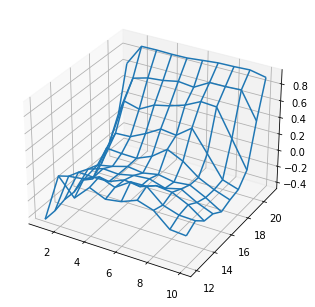

Q-value without Usable Ace


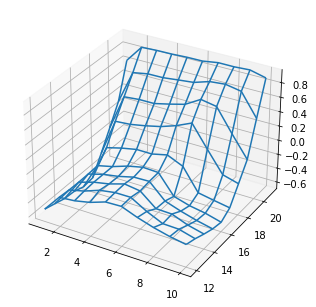

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


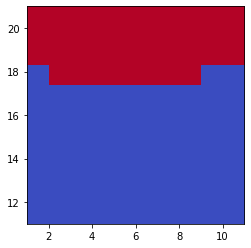

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


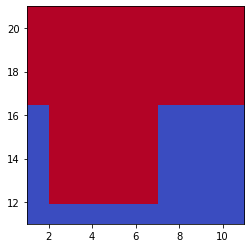

In [9]:
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace=True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace=False)
print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace=True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace=False)

----
## 9. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [27]:
mc_game = MonteCarlo()

mc_game.game(dealer, agent, deck, it=1000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :35.460%
 -- 1000 Games WIN : 339 DRAW : 44 LOSS : 617
Total win rate : 35.460%
 -- TOTAL Games WIN : 339 DRAW : 44 LOSS : 617
 -- TOTAL Games Money:  7220


### (과제 2) 플레이어의 승률을 계산

In [28]:
print('Win Rate: ' + str(mc_game.win_rate))

Win Rate: 35.46025104602511


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

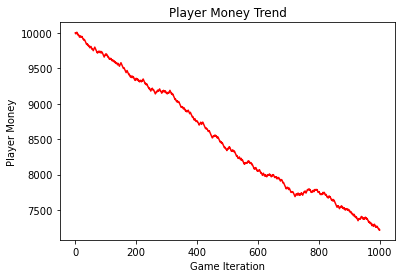

In [29]:
x = list(range(0, 1001))
y = mc_game.player_money

plt.plot(x, y, 'r')
plt.title('Player Money Trend')
plt.xlabel('Game Iteration')
plt.ylabel('Player Money')

plt.show()

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html